# Steps 3: Apply Regularization, Replace large size kernel with GAP in sequence 

## A. Target
Step 1. Add regularization to push model to learn further. Add the droupout layer at every layer except the last layer. 
IF target of 99.4% is not achieved, go to step 2
Step 2. Replace the large size kernel with GAP

## B. Results
Step 1. (Addition of Dropout (10%))
    1. Parameters: 10,970
    2. Best Training Accuracy in 15 epochs:99.20%
    3. Best Test Accuracy in 15 epochs:99.37%
    
Step 2. (Replace the 7*7 kernel by GAP)
    1. Parameters: 6,070
    2. Best Training Accuracy in 15 epochs:98.44%
    3. Best Test Accuracy in 15 epochs:98.87%
    
## C. Analysis
Step 1.(Addition of Dropout (10%))
    1. After application of dropout in all allowed layers, model is not overfitting and starts learning better but model couldn't reach to the desired levels of performance even in 20 epochs ( train accuracy = 99.31%, test accuracy = 99.33%). 
    2. We need to add capacity to model to make it learn better.
    3. We should add GAP to replace the large 7*7 kernel but it will reduce the capacity also. we can redesign the last layers to get the required learning capacity and performance

Step 2. Replace the large size kernel with GAP
    1. Model is under capcity and hence couldn't learn as expected. We need to add capacity back to the model to make it learn better.
    2. We should give the capacity to model at last layer and do the adjustments to get the model parameters in required limit of under 10K.

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

#Set Transforms - Transform part of ETL
Transforms are requried to convert the image data by applying various transformantions required. As of now, just convert image to tensor and normalize with whole dataset mean and standard deviation

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,) as this is one channel image, we have added one tuple for mean and std each 
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


## Dataset and Creating Train/Test Split - Extract part of ETL

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders - Load part of ETL

In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Exploration

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0002)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
 - Bin Count tensor([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949])
torch.Size([128, 1, 28, 28])
torch.Size([128])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


tensor(9)

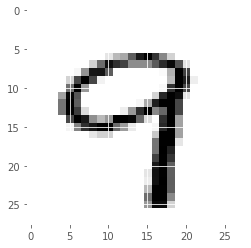

In [5]:
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))
print(' - Bin Count', train.targets.bincount()) # Output shows dataset is almost balanced

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')
torch.tensor(labels[0])


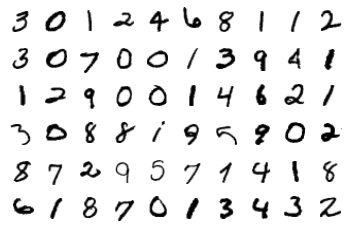

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# Find the Mean and STD

In [7]:
# simple transform
simple_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       ])
exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1305)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


# Build the Model

In [8]:
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # output_size = 26 , RF = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # output_size = 24 , RF = 5

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value)
        ) # output_size = 22 , RF = 7

        # TRANSITION BLOCK 1
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
        ) # output_size = 11 , RF = 8
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # output_size = 9 , RF = 12

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value)
        ) # output_size = 7 , RF = 16

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # output_size = 7 , RF = 16
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=7)
        ) # output_size = 1



    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.pool1(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Summary

In [9]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             900
              ReLU-6           [-1, 10, 24, 24]               0
       BatchNorm2d-7           [-1, 10, 24, 24]              20
           Dropout-8           [-1, 10, 24, 24]               0
            Conv2d-9           [-1, 20, 22, 22]           1,800
             ReLU-10           [-1, 20, 22, 22]               0
      BatchNorm2d-11           [-1, 20, 22, 22]              40
          Dropout-12           [-1, 20, 22, 22]               0
           Conv2d-13           [-1, 10, 22, 22]             200
             ReLU-14           [-1

# Train and Test Functions

In [10]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when we start your training loop, ideally we should zero out the gradients so that we do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Train Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Test Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [11]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.3008022606372833 Batch_id=468 Train Accuracy=85.31: 100%|██████████| 469/469 [00:10<00:00, 42.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2378, Test Accuracy: 9517/10000 (95.17%)

EPOCH: 1


Loss=0.1739351600408554 Batch_id=468 Train Accuracy=96.17: 100%|██████████| 469/469 [00:10<00:00, 42.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1241, Test Accuracy: 9713/10000 (97.13%)

EPOCH: 2


Loss=0.1414576917886734 Batch_id=468 Train Accuracy=96.98: 100%|██████████| 469/469 [00:10<00:00, 43.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0957, Test Accuracy: 9763/10000 (97.63%)

EPOCH: 3


Loss=0.10810170322656631 Batch_id=468 Train Accuracy=97.43: 100%|██████████| 469/469 [00:10<00:00, 43.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1210, Test Accuracy: 9680/10000 (96.80%)

EPOCH: 4


Loss=0.11219083517789841 Batch_id=468 Train Accuracy=97.64: 100%|██████████| 469/469 [00:10<00:00, 43.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0756, Test Accuracy: 9789/10000 (97.89%)

EPOCH: 5


Loss=0.1214214563369751 Batch_id=468 Train Accuracy=97.81: 100%|██████████| 469/469 [00:10<00:00, 43.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0726, Test Accuracy: 9798/10000 (97.98%)

EPOCH: 6


Loss=0.12225889414548874 Batch_id=468 Train Accuracy=97.89: 100%|██████████| 469/469 [00:11<00:00, 42.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0627, Test Accuracy: 9829/10000 (98.29%)

EPOCH: 7


Loss=0.07242002338171005 Batch_id=468 Train Accuracy=98.05: 100%|██████████| 469/469 [00:10<00:00, 43.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0483, Test Accuracy: 9876/10000 (98.76%)

EPOCH: 8


Loss=0.10294840484857559 Batch_id=468 Train Accuracy=98.10: 100%|██████████| 469/469 [00:10<00:00, 43.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0693, Test Accuracy: 9815/10000 (98.15%)

EPOCH: 9


Loss=0.02270291931927204 Batch_id=468 Train Accuracy=98.21: 100%|██████████| 469/469 [00:10<00:00, 43.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0563, Test Accuracy: 9848/10000 (98.48%)

EPOCH: 10


Loss=0.05411943793296814 Batch_id=468 Train Accuracy=98.29: 100%|██████████| 469/469 [00:10<00:00, 43.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0528, Test Accuracy: 9853/10000 (98.53%)

EPOCH: 11


Loss=0.03665093332529068 Batch_id=468 Train Accuracy=98.38: 100%|██████████| 469/469 [00:10<00:00, 43.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0465, Test Accuracy: 9874/10000 (98.74%)

EPOCH: 12


Loss=0.09016859531402588 Batch_id=468 Train Accuracy=98.39: 100%|██████████| 469/469 [00:10<00:00, 43.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0424, Test Accuracy: 9887/10000 (98.87%)

EPOCH: 13


Loss=0.0459241159260273 Batch_id=468 Train Accuracy=98.44: 100%|██████████| 469/469 [00:11<00:00, 42.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0463, Test Accuracy: 9865/10000 (98.65%)

EPOCH: 14


Loss=0.11297225207090378 Batch_id=468 Train Accuracy=98.44: 100%|██████████| 469/469 [00:10<00:00, 43.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0456, Test Accuracy: 9873/10000 (98.73%)

EPOCH: 15


Loss=0.0979677140712738 Batch_id=468 Train Accuracy=98.44: 100%|██████████| 469/469 [00:10<00:00, 43.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0514, Test Accuracy: 9853/10000 (98.53%)

EPOCH: 16


Loss=0.061694204807281494 Batch_id=468 Train Accuracy=98.46: 100%|██████████| 469/469 [00:10<00:00, 43.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0460, Test Accuracy: 9872/10000 (98.72%)

EPOCH: 17


Loss=0.05156347155570984 Batch_id=468 Train Accuracy=98.55: 100%|██████████| 469/469 [00:10<00:00, 43.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0440, Test Accuracy: 9880/10000 (98.80%)

EPOCH: 18


Loss=0.07027943432331085 Batch_id=468 Train Accuracy=98.50: 100%|██████████| 469/469 [00:10<00:00, 43.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0489, Test Accuracy: 9851/10000 (98.51%)

EPOCH: 19


Loss=0.07943577319383621 Batch_id=468 Train Accuracy=98.54: 100%|██████████| 469/469 [00:11<00:00, 42.49it/s]



Test set: Average loss: 0.0420, Test Accuracy: 9878/10000 (98.78%)



Text(0.5, 1.0, 'Test Accuracy')

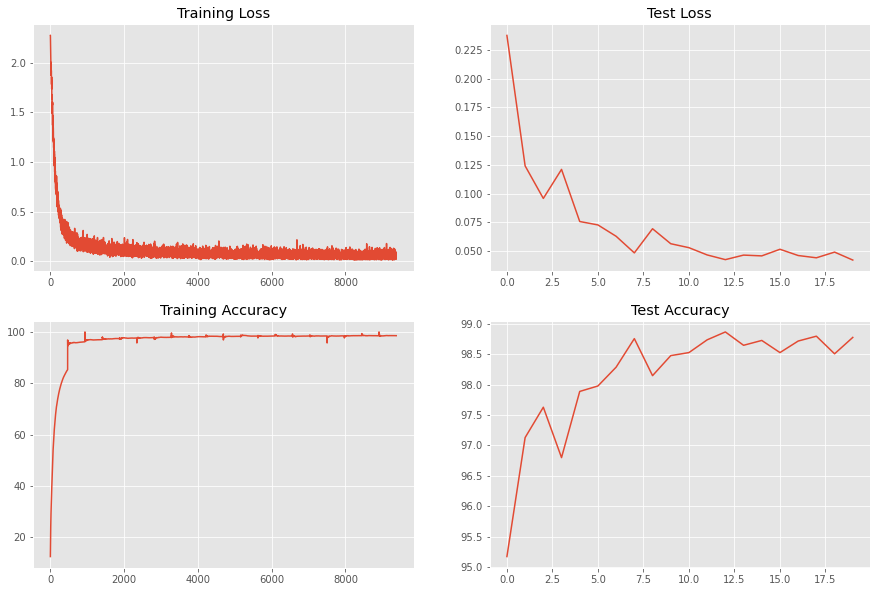

In [12]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")